## 注意！2日間にわたる動きの中の「ある日の高値 - 前日の終値」が間違っている。そしてこれはTR、ATRの計算に使われている。
## そしてTR計算自体も間違っている。「前日終値－当日安値」のところでCLDiffを使っているがこれは一足内での「終値 - 安値」だから違う。

# たくさんの指標を片っ端からdfに突っ込んで相関を見てみる

- 一つ一つの指標を作っては試し作っては試し、というやり方は非効率だからやめる。
- おそらく機械学習（あるいはその他の統計的な）手法で何らか意味のある特徴量を探索することになるが、その前に使えそうな指標をたくさん作って相関性を見てみる。
- 何か得られればさらに解析を進めるが、大きな収穫が無さそうならそこでやめておとなしく機械学習へ進む。

## やりたいこと
- 何らかの過去の指標（変数）と当日の値動き（終値 - 始値）との関に相関性を見出す。
- 相関のある複数の指標を条件としたときに、当日の値動きが上昇する条件付き確率はランダムより十分大きくなるか検証（統計解析はしない）。

## 使う指標
※ 過去N日間のデータまで使う。
- 各日の値動き
    - 終値 - 始値
    - 高値 - 安値
    - 高値 - 終値
    - 始値 - 安値
    - 真の値幅（TR)
- 2日間にわたる動き
    - ある日の終値 - 前日の終値
    - ある日の始値 - 前日の始値
    - ある日の安値 - 前日の安値
    - ある日の高値 - 前日の高値
    - ある日の出来高 - 前日の出来高
    - ある日の移動平均 - 前日の移動平均
- 過去N日間の最安値
- 過去N日間の最高値
- 各日の出来高

## 結論
- 結論を出すにはまだ早いかもしれないが、少し分析してみた感じだと、意味のある指標をうまく組み合わせてシンプルな法則を発見するには多くの時間を必要とする。

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import locale

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [2]:
df_raw = pd.read_csv('./data/N225minif_2020_exchange_daily.csv')
df_raw.info()
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3377 entries, 0 to 3376
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日付      3377 non-null   object
 1   始値      3377 non-null   int64 
 2   高値      3377 non-null   int64 
 3   安値      3377 non-null   int64 
 4   終値      3377 non-null   int64 
 5   出来高     3377 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 158.4+ KB


,日付,始値,高値,安値,終値,出来高
0,2006/7/18,14680,14715,14400,14400,22345
1,2006/7/19,14500,14650,14465,14560,20646
2,2006/7/20,14860,14975,14780,14975,17398
3,2006/7/21,14840,14875,14790,14820,14689
4,2006/7/24,14685,14870,14560,14775,22641


# 分析するためのデータを作成
- 過去N日間の価格データを使えるようにする

In [3]:
# 過去N日間のデータを扱えるようにする
lastN = 5

# 元のデータを最も古い日（＝N日前）として扱う
df = df_raw.rename(
    columns={'日付': 'date', '始値': f'o{lastN}', '高値': f'h{lastN}', '安値': f'l{lastN}', '終値': f'c{lastN}', '出来高': f'v{lastN}'}
)

for i in reversed(range(lastN)):
    inc = lastN - i
    df[f'o{i}'] = df[f'o{lastN}'][inc:].append(pd.Series([np.nan]*inc)).reset_index(drop=True)
    df[f'h{i}'] = df[f'h{lastN}'][inc:].append(pd.Series([np.nan]*inc)).reset_index(drop=True)
    df[f'l{i}'] = df[f'l{lastN}'][inc:].append(pd.Series([np.nan]*inc)).reset_index(drop=True)
    df[f'c{i}'] = df[f'c{lastN}'][inc:].append(pd.Series([np.nan]*inc)).reset_index(drop=True)
    df[f'v{i}'] = df[f'v{lastN}'][inc:].append(pd.Series([np.nan]*inc)).reset_index(drop=True)

# 日付がN日分ずれているので補正
df['date'] = df['date'][lastN:].append(pd.Series(['-']*lastN)).reset_index(drop=True)

# 過去N日分のデータを使うため、最後のN日間のデータは欠損値が発生する
#（上記の処理でとりあえずnp.nanと'-'で埋めている）
# したがって最後のN日間のデータを削除
df = df[:-lastN]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3372 entries, 0 to 3371
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3372 non-null   object 
 1   o5      3372 non-null   int64  
 2   h5      3372 non-null   int64  
 3   l5      3372 non-null   int64  
 4   c5      3372 non-null   int64  
 5   v5      3372 non-null   int64  
 6   o4      3372 non-null   float64
 7   h4      3372 non-null   float64
 8   l4      3372 non-null   float64
 9   c4      3372 non-null   float64
 10  v4      3372 non-null   float64
 11  o3      3372 non-null   float64
 12  h3      3372 non-null   float64
 13  l3      3372 non-null   float64
 14  c3      3372 non-null   float64
 15  v3      3372 non-null   float64
 16  o2      3372 non-null   float64
 17  h2      3372 non-null   float64
 18  l2      3372 non-null   float64
 19  c2      3372 non-null   float64
 20  v2      3372 non-null   float64
 21  o1      3372 non-null   float64
 22  

# ターゲット指標は当日の値動き（終値 - 始値）とする

In [4]:
df['CODiff0'] = df['c0'] - df['o0']

# 指標の計算と追加

In [5]:
# 各日の値動き
for i in range(1, lastN+1):
    df[f'CODiff{i}'] = df[f'c{i}'] - df[f'o{i}'] # 終値 - 始値
    df[f'HLDiff{i}'] = df[f'h{i}'] - df[f'l{i}'] # 高値 - 安値
    df[f'HCDiff{i}'] = df[f'h{i}'] - df[f'c{i}'] # 高値 - 終値
    df[f'OLDiff{i}'] = df[f'o{i}'] - df[f'l{i}'] # 始値 - 安値
    df[f'CLDiff{i}'] = df[f'c{i}'] - df[f'l{i}'] # 終値 - 安値

In [6]:
# N日移動平均
# とりあえず4日固定
# 例："C4Avg1" は、4日前～1日前までの4日移動平均値
nBars = 4
for i in range(1, (lastN+1) - (nBars-1)):
    df[f'C{nBars}Avg{i}'] = df[[f'c{j}' for j in range(i, i+nBars)]].mean(axis=1)

# ある日の移動平均 - 前日の移動平均
# 例："C4AvgSlope1" は、2日前の4日移動平均値から1日前の4日移動平均値への変化量
for i in range(1, (lastN+1) - (nBars-1) - 1):
    df[f'C{nBars}AvgSlope{i}'] = df[f'C{nBars}Avg{i}'] - df[f'C{nBars}Avg{i+1}']

In [7]:
# 2日間にわたる動き
for i in range(1, lastN):
    df[f'CSlope{i}'] = df[f'c{i}'] - df[f'c{i+1}'] # ある日の終値 - 前日の終値
    df[f'OSlope{i}'] = df[f'o{i}'] - df[f'o{i+1}'] # ある日の始値 - 前日の始値
    df[f'LSlope{i}'] = df[f'l{i}'] - df[f'l{i+1}'] # ある日の安値 - 前日の安値
    df[f'HSlope{i}'] = df[f'h{i}'] - df[f'h{i+1}'] # ある日の高値 - 前日の高値
    df[f'VSlope{i}'] = df[f'v{i}'] - df[f'v{i+1}'] # ある日の出来高 - 前日の出来高
    df[f'HCSlope{i}'] = df[f'l{i}'] - df[f'c{i+1}'] # ある日の高値 - 前日の終値

In [10]:
# 真の値幅（TR）
'''
1日の最大の値動きTR（True Range）
（1）当日の高値と前日の終値の差→当日の高値－前日の終値
（2）前日の終値と当日の安値の差→前日終値－当日安値
（3）当日の高値と当日の安値の差→当日の高値－当日の安値
以上のうちもっとも大きいものがTR
'''
for i in range(1, lastN):
    df[f'TR{i}'] = df[[f'HCSlope{i}', f'CLDiff{i}', f'HLDiff{i}']].max(axis=1)

In [11]:
# 過去N日間の最安値
df[f'L{lastN}min1'] = df[[f'l{n}' for n in range(1,lastN+1)]].min(axis=1)

# 過去N日間の最高値
df[f'H{lastN}max1'] = df[[f'h{n}' for n in range(1,lastN+1)]].max(axis=1)

In [12]:
# 指標として不要な列を削除
dfp = df.copy()
for i in range(lastN+1):
    dfp = dfp.drop([f'o{i}', f'c{i}', f'h{i}', f'l{i}', f'v{i}'], axis=1)

dfp = dfp.drop(['date'], axis=1)
dfp = dfp.drop([f'C{nBars}Avg{n}' for n in range(1, (lastN+1) - (nBars-1))], axis=1)

In [13]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3372 entries, 0 to 3371
Data columns (total 57 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CODiff0      3372 non-null   float64
 1   CODiff1      3372 non-null   float64
 2   HLDiff1      3372 non-null   float64
 3   HCDiff1      3372 non-null   float64
 4   OLDiff1      3372 non-null   float64
 5   CLDiff1      3372 non-null   float64
 6   CODiff2      3372 non-null   float64
 7   HLDiff2      3372 non-null   float64
 8   HCDiff2      3372 non-null   float64
 9   OLDiff2      3372 non-null   float64
 10  CLDiff2      3372 non-null   float64
 11  CODiff3      3372 non-null   float64
 12  HLDiff3      3372 non-null   float64
 13  HCDiff3      3372 non-null   float64
 14  OLDiff3      3372 non-null   float64
 15  CLDiff3      3372 non-null   float64
 16  CODiff4      3372 non-null   float64
 17  HLDiff4      3372 non-null   float64
 18  HCDiff4      3372 non-null   float64
 19  OLDiff

# 各指標と当日値動きとの相関性を見る

In [14]:
# 'CODiff0'と他の指標との関係を回帰プロットする
# 処理時間が以上にかかるのでコメントアウトしている
SAVE_DIR = 'plots/NIKKEI225mini-EDA-05'
def plot_save(x_label, data):
    target = 'CODiff0'
    plot = sns.lmplot(x_label, target, data=dfp)
    plot.savefig(f'{SAVE_DIR}/lmplot_{x_label}_{target}.png')

'''
for x_label in dfp.columns:
    if x_label == 'CODiff0':
        continue

    plot_save(x_label, dfp)
'''

"\nfor x_label in dfp.columns:\n    if x_label == 'CODiff0':\n        continue\n\n    plot_save(x_label, dfp)\n"

In [15]:
# 変数同士の相関を見る
dfp.corr().style.background_gradient(cmap='summer_r')

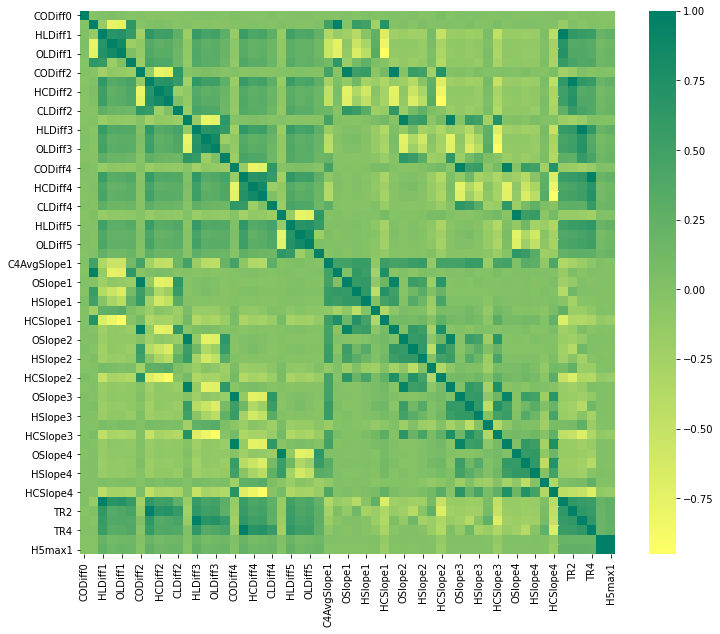

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
sns.heatmap(dfp.corr(), cmap='summer_r', ax=ax)

In [17]:
# 'CODiff0'との相関が大きい順に並べる
dfp.corr()['CODiff0'].sort_values(ascending=False)

CODiff0        1.000000
HCSlope2       0.050997
HCDiff1        0.039985
LSlope2        0.031341
HSlope1        0.031280
CODiff4        0.025741
OSlope3        0.024886
CLDiff4        0.024079
CSlope4        0.023216
HSlope3        0.021822
HCDiff3        0.019495
CSlope2        0.018589
LSlope3        0.018288
OSlope1        0.013779
OLDiff1        0.012756
HLDiff1        0.012283
TR1            0.012216
HCDiff5        0.010386
OLDiff5        0.010259
HCSlope4       0.009667
CODiff2        0.007303
C4AvgSlope1    0.005934
HSlope4        0.005054
HLDiff4        0.004374
TR3            0.004303
TR4            0.004170
HLDiff3        0.004041
OSlope2        0.002835
VSlope3        0.002403
HCSlope3       0.001660
VSlope4        0.000712
VSlope1       -0.001029
LSlope4       -0.002150
HLDiff5       -0.002330
OLDiff3       -0.002428
HCSlope1      -0.003821
CODiff3       -0.008955
CSlope3       -0.009203
VSlope2       -0.010150
OLDiff4       -0.012574
CLDiff5       -0.014590
HSlope2       -0

# 相関の大きい指標から順に条件適用していき、当日上昇確率をどれだけ高められるか
上でやった相関分析の結果で、単純に相関が大きかった指標から順に条件適用する。
- 注意点として、これは各指標が独立だという仮定に基づくが、実際には独立ではないから、単純に条件を掛け合わせてうまくいく根拠はない。単に、もしこのシンプルなやり方が機能すればラッキーという程度のもの。

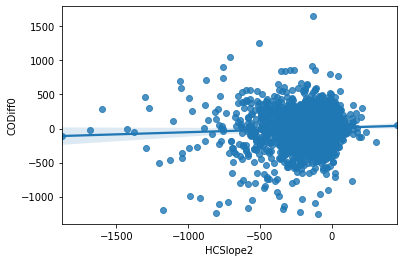

In [19]:
# HCSlope2とCODiff0は正相関
# つまり、2日前における（高値 - その前日の終値）が大きいほど当日の値動きが正方向に大きいということ
sns.regplot('HCSlope2', 'CODiff0', data=dfp)

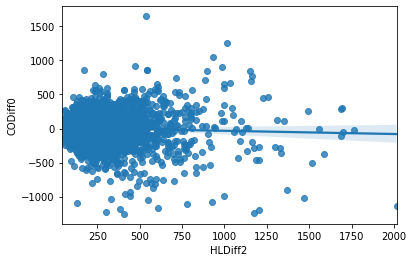

In [18]:
# HLDiff2とCODiff0は逆相関
# つまり、2日前の値幅（高値 - 安値）が小さい時は当日上昇しやすいということ
sns.regplot('HLDiff2', 'CODiff0', data=dfp)

In [38]:
# 相関係数の絶対値が0.025以上の指標から当日上昇を予測してみる
from sklearn.linear_model import LogisticRegression
x = dfp[['HCSlope2', 'HCDiff1', 'LSlope2', 'HSlope1', 'CODiff4', 'LSlope1', 'CLDiff1', 'CODiff1', 'CLDiff2', 'OLDiff2', 'HLDiff2']]
y = dfp['CODiff0'] <= 0 # この値以上の場合にFalseになる、つまり0になるから、この値以上になることが「真」と予測されることになる。
lrm = LogisticRegression()
lrm.fit(x, y)
lrm

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
y_pred = lrm.predict(x)
print(f'confusion matrix: {confusion_matrix(y_true=y, y_pred=y_pred)}')
print(f'accuracy: {accuracy_score(y_true=y, y_pred=y_pred)}')
print('precision: ', precision_score(y_true=y, y_pred=y_pred))
print('recall: ', recall_score(y_true=y, y_pred=y_pred))
print('f1 score: ', f1_score(y_true=y, y_pred=y_pred))

confusion matrix: [[1434  323]
 [1243  372]]
accuracy: 0.5355871886120996
precision:  0.5352517985611511
recall:  0.23034055727554179
f1 score:  0.3220779220779221
